In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("data/coords/coords_HDB.csv")
df.flat_model.unique()

array(['NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'APARTMENT', '2-ROOM', 'PREMIUM APARTMENT', 'MODEL A2',
       'MODEL A-MAISONETTE', 'MAISONETTE', 'IMPROVED-MAISONETTE',
       'PREMIUM MAISONETTE'], dtype=object)

In [2]:
#remove masionette since we already know that flat type from the flat model
process1 = df.loc[df['flat_model']!='MODEL A-MAISONETTE']
process1 = process1.loc[df['flat_model']!='MAISONETTE']
process1 = process1.loc[df['flat_model']!='IMPROVED-MAISONETTE']
process1 = process1.loc[df['flat_model']!='PREMIUM MAISONETTE']

#flat_type lost
Y = process1['flat_type']
process2 = process1.drop(['flat_type', 'town', 'block', 'street_name',
                          'storey_range', 'mth_sold', 'lat', 'long'], axis=1)
process2.columns

Index(['floor_area_sqm', 'flat_model', 'resale_price', 'year_sold',
       'age_sold'],
      dtype='object')

In [3]:
X = pd.get_dummies(data=process2, drop_first=True)
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X)

In [4]:
from sklearn.decomposition import PCA

# Create a PCA model with 5 dimensions
dim = 5
pca = PCA(n_components=dim).fit(X_scaled)

# find variance explained by top PCA dimensions
X_reduced = pca.transform(X_scaled)
print(pca.explained_variance_ratio_)

# get most important feature for each PCA dimension
most_important = [np.abs(pca.components_[i]).argmax() for i in range(dim)]
initial_feature_names = list(X.columns)
most_important_names = [initial_feature_names[most_important[i]] for i in range(dim)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(dim)}

PC_impt = pd.DataFrame(dic.items())
PC_impt

[0.31253752 0.26230171 0.10994795 0.09718158 0.06627704]


,0,1
0,PC0,flat_model_MODEL A
1,PC1,flat_model_NEW GENERATION
2,PC2,flat_model_SIMPLIFIED
3,PC3,year_sold
4,PC4,flat_model_SIMPLIFIED


In [5]:
from sklearn.cluster import KMeans
#6 for 1-room, 2-room, 3-room, 4-room, 5-room, executive
kmeans = KMeans(n_clusters=6)

PCA_components = pd.DataFrame(X_reduced)
yhat = kmeans.fit_predict(PCA_components)
yhat

array([2, 2, 2, ..., 0, 3, 3])

In [6]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2','PC3','PC4','PC5'])
X_reduceddf['cluster'] = yhat
X_reduceddf.head()

,PC1,PC2,PC3,PC4,PC5,cluster
0,-0.173037,0.886215,-0.342056,0.320004,0.128430,2
1,-0.172294,0.881727,-0.340226,0.320509,0.142322,2
2,-0.172216,0.881238,-0.339980,0.320441,0.143767,2
3,-0.173678,0.881690,-0.338044,0.312759,0.137520,2
4,-0.171825,0.878797,-0.338751,0.320103,0.150992,2


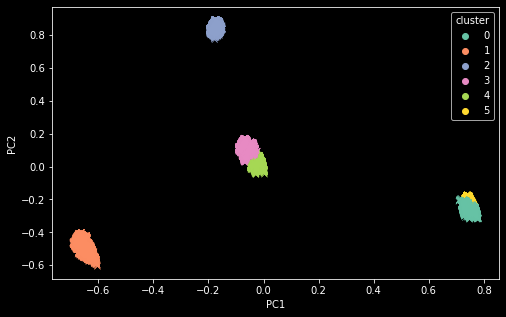

In [7]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

plt.figure(figsize=(8, 5))
plt.xlabel('PC1')
plt.ylabel('PC2')

sc = sns.scatterplot(x=X_reduceddf["PC1"], y=X_reduceddf["PC2"], data=X_reduceddf,
                     palette="Set2", hue=X_reduceddf["cluster"], marker='x')

fig = sc.get_figure()

# for checking only

In [25]:
check = process1.floor_area_sqm.to_frame()
check["true"] = Y
check["predicted"] = yhat

check.head()

,floor_area_sqm,true,predicted
0,81.0,4 ROOM,2
1,91.0,4 ROOM,2
2,92.0,4 ROOM,2
3,92.0,4 ROOM,2
4,97.0,4 ROOM,2


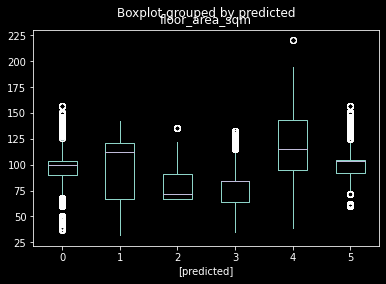

In [26]:
check.boxplot(by =["predicted"], column =['floor_area_sqm'], grid = False);

In [27]:
check.loc[check.predicted == 0, "predicted"] = "1 ROOM" ## 
check.loc[check.predicted == 1, "predicted"] = "5 ROOM" ## 
check.loc[check.predicted == 2, "predicted"] = "3 ROOM" ## 
#cluster 3,4 nearest probably 5 room, executive
check.loc[check.predicted == 3, "predicted"] = "2 ROOM" ## 
check.loc[check.predicted == 4, "predicted"] = "EXECUTIVE" ## 
check.loc[check.predicted == 5, "predicted"] = "4 ROOM" ## 

In [28]:
check['acc'] = np.where((check['predicted'] == check['true']), 1, 0)
check.acc.sum()/check.shape[0]*100

47.93116798899148